In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

In [4]:
df = pd.read_excel('WomenArtists.xlsx')
name_a = [re.sub(',', '', name) for name in df[~df['A'].isnull()]['A']]
name_a = [re.sub("\(.*\)", "", name).strip().lower() for name in name_a]
name_raw = list(df[~df['A'].isnull()]['A'])
brith_yr = list(df[~df['A'].isnull()]['DoB'])

In [7]:
df.columns

Index(['Micky Allan', 'Unnamed: 1', 'A', 'DoB', 'Place of Birth', 'Region',
       'DoD', 'Place of Death', 'Date, Place Arrival', 'Education',
       'Gallery 1', 'Gallery 2', 'Art Movements', 'Genre', 'Key works',
       'Date (works)', 'End works', 'Exhibitions', 'Exhibition dates',
       'Other employment', 'Resides', 'Awards', 'Criticism', 'Resources'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Micky Allan          299 non-null    object 
 1   Unnamed: 1           0 non-null      float64
 2   A                    281 non-null    object 
 3   DoB                  142 non-null    object 
 4   Place of Birth       38 non-null     object 
 5   Region               29 non-null     object 
 6   DoD                  53 non-null     float64
 7   Place of Death       17 non-null     object 
 8   Date, Place Arrival  1 non-null      object 
 9   Education            0 non-null      float64
 10  Gallery 1            0 non-null      float64
 11  Gallery 2            0 non-null      float64
 12  Art Movements        5 non-null      object 
 13  Genre                0 non-null      float64
 14  Key works            0 non-null      float64
 15  Date (works)         5 non-null      obj

In [5]:
df.describe()

,Unnamed: 1,DoD,Education,Gallery 1,Gallery 2,Genre,Key works,End works,Other employment,Resides,Awards,Criticism,Resources
count,0.0,53.000000,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.0,0.0
mean,NaN,1989.924528,NaN,NaN,NaN,NaN,NaN,1994.500000,NaN,NaN,NaN,NaN,NaN
std,NaN,24.365683,NaN,NaN,NaN,NaN,NaN,0.707107,NaN,NaN,NaN,NaN,NaN
min,NaN,1935.000000,NaN,NaN,NaN,NaN,NaN,1994.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,1968.000000,NaN,NaN,NaN,NaN,NaN,1994.250000,NaN,NaN,NaN,NaN,NaN
50%,NaN,1999.000000,NaN,NaN,NaN,NaN,NaN,1994.500000,NaN,NaN,NaN,NaN,NaN
75%,NaN,2011.000000,NaN,NaN,NaN,NaN,NaN,1994.750000,NaN,NaN,NaN,NaN,NaN
max,NaN,2021.000000,NaN,NaN,NaN,NaN,NaN,1995.000000,NaN,NaN,NaN,NaN,NaN


In [6]:
def into_url(name):
    url = f'https://www.aasd.com.au/index.cfm/search/?Name={name}&all=0&Scope=0&Submit='
    url = url.replace(" ", "%20")
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    
    try:
        if soup.find_all('p', class_="callout callout-danger"):
            return None

        else:
            table = soup.find('table', class_="table table-striped").find('tbody')
            return find_info(table, count)
    except KeyError:
        pass

In [10]:
def find_info(table, count):
    global auct_data
    medium = {'medium_1': 0, 'medium_2': 0, 'medium_3': 0, 'medium_4': 0, 'medium_5': 0}

    for row in table.find_all('tr'):
        name = row.find('a').text.lower().split()
        name = re.sub(',', '', str(name))
        birth = row.find_all('td')[2].text.split('-')[0]
        nwork_1970s_2021 = row.find_all('td')[4].text
        nwork_2022 = row.find_all('td')[5].text
        raw_name = name_a[count].split()[0]
        
        if raw_name in name and birth == str(brith_yr[count]):
            for ul in row.find_all('ul', class_="list-inline mediums"):
                for li in ul.find_all('li'):
                    type_ = re.findall(r'class="(.*)"', str(li).split()[1])[0]
                    if type_:
                        medium[type_] = 1
                        
            root_link = row.find_all("a", href=True)[0]["href"]
            auct_data = auct_info(root_link, count)
            
            break
            
    return [nwork_1970s_2021, nwork_2022, medium, auct_data]

In [8]:
def auct_info(root_link, count):
    # Access the artist's profile
    link = f'https://www.aasd.com.au{root_link}'
    profile_page = requests.get(link)
    profile_soup = BeautifulSoup(profile_page.content, "html.parser")

    # link to access 'Auction Houses that have sold works by this artist'
    web_for_price = re.findall(r'a href="(\S+)">Auction Houses that have sold works by this artist',str(profile_soup.find('div', class_="row")))
    auct_price_page = requests.get(f'https://www.aasd.com.au/{web_for_price[0]}')
    auct_data = pd.read_html(f'https://www.aasd.com.au/{web_for_price[0]}')[0]
    auct_data['name_raw'] = name_raw[count]

    return auct_data

In [11]:
count = 0
auct_count = 0
# data = {'Paintings':[], 'Works on Paper':[], 'Prints & Graphics':[], 'Photographs':[], 'Objects':[]}
# auct_df = pd.DataFrame(columns=['Auction House', 'Value Sold', 'Number Sold', 'name_raw'])
data = {'nwork_1970s_2021': [],'nwork_2022': [], 'medium_1': [], 'medium_2': [], 'medium_3': [], 'medium_4': [], 'medium_5': []}


for name in name_a:
    
    if into_url(name) == None:
        data['nwork_1970s_2021'].append('')
        data['nwork_2022'].append('')
        for i in range(5):
            data[f'medium_{i+1}'].append(0)
                
    else:
        [nwork_1970s_2021, nwork_2022, medium, auct_data] = into_url(name)
        
        if auct_count == 0:
            auct_df = auct_data
        else:
            auct_df = pd.concat([auct_df, auct_data])
            
        auct_count += 1
        
        data['nwork_1970s_2021'].append(nwork_1970s_2021)
        data['nwork_2022'].append(nwork_2022)
        medium = list(medium.items())
        for i in range(5):
            data[medium[i][0]].append(medium[i][1])
            
    if count%10 == 0:
        print(count)
    
    count += 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


In [13]:
data_copy = data

In [14]:
data['name_raw'] = name_raw

In [15]:
df_scrap = pd.DataFrame(data)
# csv file
df_scrap.to_csv('auction_data.csv')
# excel file
df_scrap.to_excel("auction_data.xlsx")

In [16]:
# csv file
auct_df.to_csv('auction_price_data.csv')
# excel file
auct_df.to_excel("auction_price_data.xlsx")

In [17]:
n_artists = len(df_scrap[df_scrap['nwork_1970s_2021']!=''])
print(f'number of artists we found is {n_artists} out of {len(name_a)}')

number of artists we found is 175 out of 281


---

# Data Exploration

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

In [11]:
df_art = pd.read_csv('auction_data.csv')
df_art.head(10)

,Unnamed: 0,nwork_1970s_2021,nwork_2022,medium_1,medium_2,medium_3,medium_4,medium_5,name_raw
0,0,NaN,NaN,0,0,0,0,0,"Alder, Alison"
1,1,26,1.0,1,1,1,1,0,"Allan, Micky"
2,2,75,4.0,1,1,1,0,1,"Apuatimi, Jean Baptiste (Pulukatu)"
3,3,178,5.0,1,1,1,0,0,"Audette, Yvonne"
4,4,NaN,NaN,0,0,0,0,0,"(Budden) Phoenix, Frances"
5,5,NaN,NaN,0,0,0,0,0,"Baas-Backing, Solvig"
6,6,NaN,NaN,0,0,0,0,0,"Baker, Nyukana"
7,7,388,3.0,1,1,0,0,0,"Bale, Alice Marian Ellen"
8,8,405,10.0,1,1,1,0,0,"Beckett, Clarice"
9,9,NaN,NaN,0,0,0,0,0,"Bell, Eugenie Keefer"


In [19]:
df_art.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        281 non-null    int64  
 1   nwork_1970s_2021  175 non-null    object 
 2   nwork_2022        175 non-null    float64
 3   medium_1          281 non-null    int64  
 4   medium_2          281 non-null    int64  
 5   medium_3          281 non-null    int64  
 6   medium_4          281 non-null    int64  
 7   medium_5          281 non-null    int64  
 8   name_raw          281 non-null    object 
dtypes: float64(1), int64(6), object(2)
memory usage: 19.9+ KB


In [23]:
round(df_art.describe())

,Unnamed: 0,nwork_2022,medium_1,medium_2,medium_3,medium_4,medium_5
count,281.0,175.0,281.0,281.0,281.0,281.0,281.0
mean,140.0,3.0,0.0,0.0,0.0,0.0,0.0
std,81.0,4.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,70.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,140.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,210.0,4.0,0.0,0.0,0.0,0.0,0.0
max,280.0,31.0,1.0,1.0,1.0,1.0,1.0


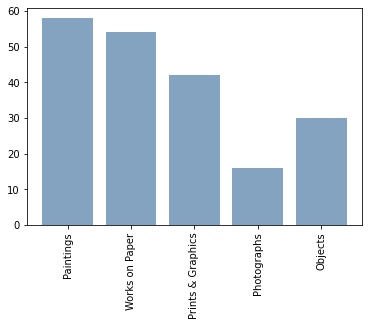

<Figure size 1500x1000 with 0 Axes>

In [9]:
x_labels = ['Paintings', 'Works on Paper', 'Prints & Graphics', 'Photographs', 'Objects']

# create a dataset
height = df_art.sum(axis=0)[2:7]
bars = ['medium_1', 'medium_2','medium_3','medium_4', 'medium_5']
x_pos = np.arange(len(bars))

# Create bars
plt.bar(x_pos, height, color=(0.2, 0.4, 0.6, 0.6))

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.xticks(x_pos, x_labels, rotation='vertical')

figure(figsize=(15, 10), dpi=100)

# Show graph
plt.show()

In [67]:
df_art.sum(axis=0)[2:7]

medium_1    58
medium_2    54
medium_3    42
medium_4    16
medium_5    30
dtype: object

In [24]:
import pandas as pd
df_price = pd.read_csv('auction_price_data.csv')
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1799 non-null   int64  
 1   Auction House  1799 non-null   object 
 2   Value Sold     1799 non-null   object 
 3   Number Sold    1799 non-null   int64  
 4   name_raw       1799 non-null   object 
 5   Unnamed: 5     0 non-null      float64
 6   sold           1799 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 98.5+ KB


In [26]:
df_price.sort_values(by ='sold', ascending=False)

,Unnamed: 0,Auction House,Value Sold,Number Sold,name_raw,Unnamed: 5,sold
284,0,Sotheby's,"$4,666,890",93,"Cossington Smith, Grace",NaN,4666890
536,0,"Deutscher and Hackett, South Yarra VIC","$3,217,524",27,"Gascoigne, Rosalie",NaN,3217524
537,1,Sotheby's,"$3,163,326",40,"Gascoigne, Rosalie",NaN,3163326
285,1,"Deutscher and Hackett, South Yarra VIC","$2,719,405",30,"Cossington Smith, Grace",NaN,2719405
761,0,"Deutscher and Hackett, South Yarra VIC","$2,479,732",37,"Kathryn Barton, Del",NaN,2479732
...,...,...,...,...,...,...,...
7,7,Cromwell's Sydney,$46,1,"Allan, Micky",NaN,46
812,17,"Lawson~Menzies (now trading as Menzies), South...","$3,000",1,"Lahey, Vida",NaN,30
200,1,"Geoff K. Gray, Homebush NSW","$2,000",1,"Broome-Norton, Jean",NaN,20
198,1,"Geoff K. Gray, Homebush NSW","$2,000",1,"Broome-Norton, Jean",NaN,20


In [54]:
sold_grpby_name = df_price.groupby('name_raw')['sold'].nlargest(1)
dict_sold = sold_grpby_name.sort_values(ascending=False).to_dict()

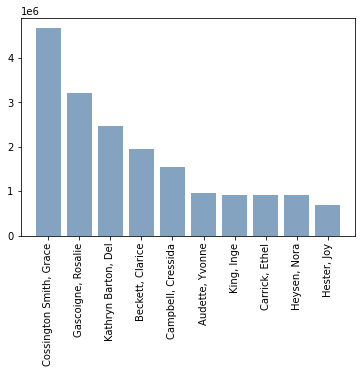

<Figure size 15000x10000 with 0 Axes>

In [72]:
# Top 10 Artists (according to their artwork prices)

x_labels = [i[0] for i in dict_sold.keys()][:10]

# create a dataset
height = [i for i in dict_sold.values()][:10]
bars = x_labels
x_pos = np.arange(len(x_labels))

# Create bars
plt.bar(x_pos, height, color=(0.2, 0.4, 0.6, 0.6))

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.xticks(x_pos, x_labels, rotation='vertical')

figure(figsize=(150, 100), dpi=100)

# Show graph
plt.show()

In [74]:
df_price.sort_values(by ='sold', ascending=False).head(10)

,Unnamed: 0,Auction House,Value Sold,Number Sold,name_raw,Unnamed: 5,sold
284,0,Sotheby's,"$4,666,890",93,"Cossington Smith, Grace",NaN,4666890
536,0,"Deutscher and Hackett, South Yarra VIC","$3,217,524",27,"Gascoigne, Rosalie",NaN,3217524
537,1,Sotheby's,"$3,163,326",40,"Gascoigne, Rosalie",NaN,3163326
285,1,"Deutscher and Hackett, South Yarra VIC","$2,719,405",30,"Cossington Smith, Grace",NaN,2719405
761,0,"Deutscher and Hackett, South Yarra VIC","$2,479,732",37,"Kathryn Barton, Del",NaN,2479732
538,2,Deutscher~Menzies,"$2,160,770",25,"Gascoigne, Rosalie",NaN,2160770
286,2,Christies,"$2,105,871",101,"Cossington Smith, Grace",NaN,2105871
64,0,"Deutscher and Hackett, South Yarra VIC","$1,942,256",33,"Beckett, Clarice",NaN,1942256
539,3,"Bonhams, Woollahra NSW","$1,638,460",12,"Gascoigne, Rosalie",NaN,1638460
204,1,Sotheby's,"$1,549,870",22,"Campbell, Cressida",NaN,1549870
